In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [4]:
!pip install openmeteo-requests requests-cache retry-requests pandas numpy matplotlib cartopy

  Using cached requests_cache-1.2.0-py3-none-any.whl (61 kB)
  Using cached retry_requests-2.0.0-py3-none-any.whl (15 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 33.0 MB/s eta 0:00:00
  Using cached cattrs-23.2.3-py3-none-any.whl (57 kB)
  Using cached url_normalize-1.4.3-py2.py3-none-any.whl (6.8 kB)


In [8]:
import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 52.52,
	"longitude": 13.41,
	"start_date": "2023-01-01",
	"end_date": "2024-01-01",
	"hourly": ["wind_speed_100m", "wind_direction_100m"],
	"models": "best_match"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_wind_speed_100m = hourly.Variables(0).ValuesAsNumpy()
hourly_wind_direction_100m = hourly.Variables(1).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
hourly_data["wind_speed_100m"] = hourly_wind_speed_100m
hourly_data["wind_direction_100m"] = hourly_wind_direction_100m

hourly_dataframe = pd.DataFrame(data = hourly_data)
print(hourly_dataframe)


Coordinates 52.5483283996582°N 13.407821655273438°E
Elevation 38.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
                          date  wind_speed_100m  wind_direction_100m
0    2023-01-01 00:00:00+00:00        50.554047           234.272507
1    2023-01-01 01:00:00+00:00        50.112461           232.883057
2    2023-01-01 02:00:00+00:00        50.765106           233.942657
3    2023-01-01 03:00:00+00:00        47.088493           233.392838
4    2023-01-01 04:00:00+00:00        46.340820           226.258972
...                        ...              ...                  ...
8779 2024-01-01 19:00:00+00:00        30.430117           244.041290
8780 2024-01-01 20:00:00+00:00        29.498039           246.250488
8781 2024-01-01 21:00:00+00:00        30.821552           247.328613
8782 2024-01-01 22:00:00+00:00        30.158459           246.801392
8783 2024-01-01 23:00:00+00:00        25.294964           245.623535

[8784 rows x 3 columns]


In [30]:
print(grouped_data)


    latitude  date  wind_speed_100m
0          0     1        22.725940
1          0     2        23.267798
2          0     3        17.787952
3          0     4        15.048267
4          0     5        19.520929
5          0     6        20.070834
6          0     7        22.586983
7          0     8        19.860020
8          0     9        20.878670
9          0    10        18.222188
10         0    11        15.257499
11         0    12        15.895571
12        30     1        27.181888
13        30     2        27.191606
14        30     3        24.098854
15        30     4        24.066616
16        30     5        24.521417
17        30     6        22.255451
18        30     7        23.041534
19        30     8        22.726163
20        30     9        21.560420
21        30    10        22.729776
22        30    11        21.675279
23        30    12        24.043412
24        45     1        27.117862
25        45     2        24.719444
26        45     3        23

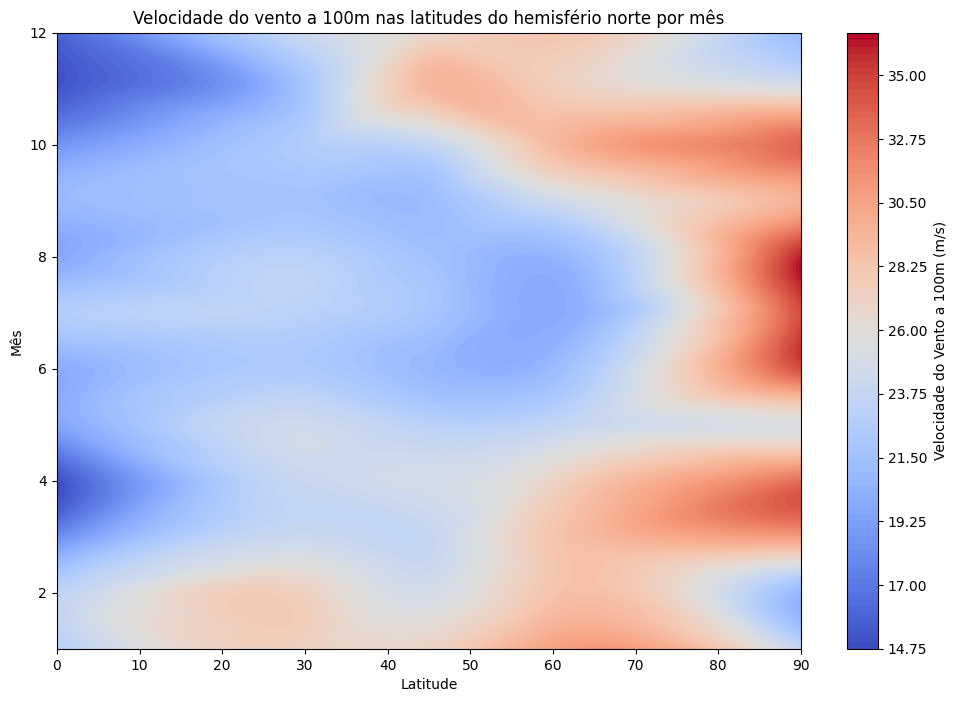

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import openmeteo_requests
import requests_cache
from retry_requests import retry
from scipy.interpolate import griddata

# Configuração inicial para coleta de dados via Open-Meteo API
cache_session = requests_cache.CachedSession('.cache', expire_after=-1)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

# Lista de coordenadas
locations = [(lat, lon) for lat in [0, 30, 45, 60, 90] for lon in [0, 45, 90, 135, 180]]

# Lista para armazenar DataFrames de dados horários
hourly_dataframes = []

# Parâmetros para solicitações à API
params_common = {
    "start_date": "2023-01-01",
    "end_date": "2024-01-01",
    "hourly": ["wind_speed_100m", "wind_direction_100m"],
    "models": "best_match"
}

# Iterar sobre coordenadas, solicitar e processar dados
for latitude, longitude in locations:
    params = params_common.copy()
    params["latitude"] = latitude
    params["longitude"] = longitude

    try:
        responses = openmeteo.weather_api("https://archive-api.open-meteo.com/v1/archive", params=params)
        response = responses[0]
        hourly = response.Hourly()

        hourly_wind_speed_100m = hourly.Variables(0).ValuesAsNumpy()
        hourly_wind_direction_100m = hourly.Variables(1).ValuesAsNumpy()

        hourly_data = {
            "date": pd.date_range(
                start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
                end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
                freq=pd.Timedelta(seconds=hourly.Interval()),
                inclusive="left"
            ),
            "latitude": [latitude] * len(hourly_wind_speed_100m),
            "longitude": [longitude] * len(hourly_wind_speed_100m),
            "wind_speed_100m": hourly_wind_speed_100m,
            "wind_direction_100m": hourly_wind_direction_100m
        }
        hourly_dataframe = pd.DataFrame(data=hourly_data)

        hourly_dataframes.append(hourly_dataframe)
    except Exception as e:
        print(f"Error fetching data for latitude {latitude}, longitude {longitude}: {e}")

# Concatenação e agrupamento dos dados
hourly_dataframe_all = pd.concat(hourly_dataframes, ignore_index=True)
grouped_data = hourly_dataframe_all.groupby(['latitude', hourly_dataframe_all['date'].dt.month])['wind_speed_100m'].mean().reset_index()

# Adição de ruído aleatório para simulação
grouped_data['wind_speed_100m'] += np.random.normal(0, 0.1, grouped_data.shape[0])

# Preparação dos dados para a plotagem
x = grouped_data['latitude']
y = grouped_data['date']
z = grouped_data['wind_speed_100m']

xi, yi = np.meshgrid(np.linspace(x.min(), x.max(), 100), np.linspace(y.min(), y.max(), 100))
zi = griddata((x, y), z, (xi, yi), method='cubic')

# Plotagem dos dados suavizados
plt.figure(figsize=(12, 8))
plt.contourf(xi, yi, zi, levels=100, cmap='coolwarm')
plt.colorbar(label='Velocidade do Vento a 100m (m/s)')
plt.xlabel('Latitude')
plt.ylabel('Mês')
plt.title('Velocidade do vento a 100m nas latitudes do hemisfério norte por mês')
plt.show()


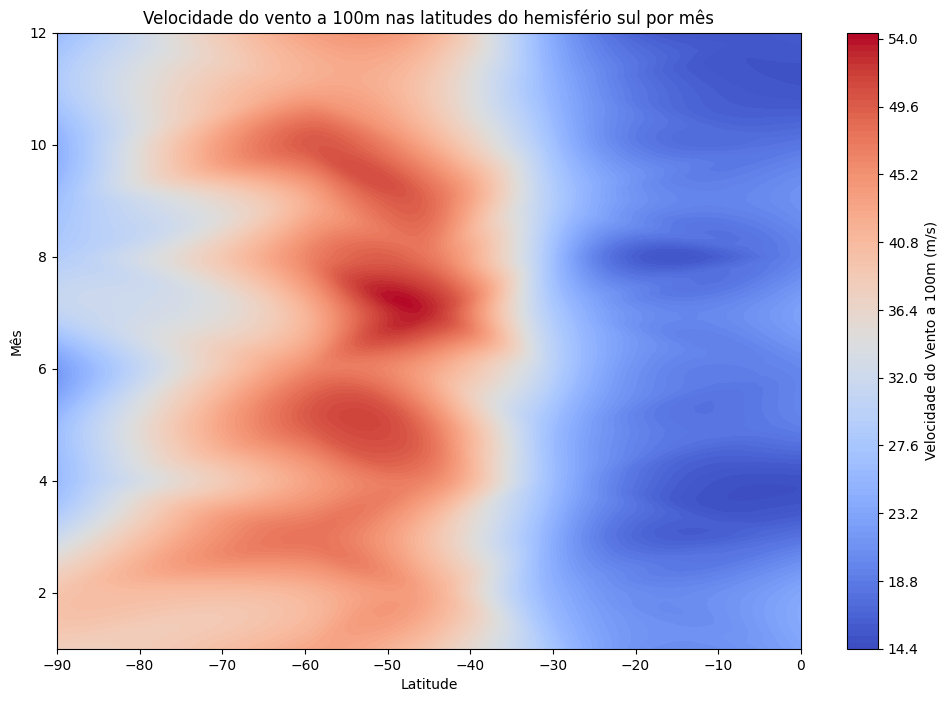

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import openmeteo_requests
import requests_cache
from retry_requests import retry
from scipy.interpolate import griddata

# Configuração inicial para coleta de dados via Open-Meteo API
cache_session = requests_cache.CachedSession('.cache', expire_after=-1)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

# Lista de coordenadas ajustada para o hemisfério sul
locations = [(-lat, lon) for lat in [0, 30, 45, 60, 90] for lon in [0, 45, 90, 135, 180]]

# Lista para armazenar DataFrames de dados horários
hourly_dataframes = []

# Parâmetros para solicitações à API
params_common = {
    "start_date": "2023-01-01",
    "end_date": "2024-01-01",
    "hourly": ["wind_speed_100m", "wind_direction_100m"],
    "models": "best_match"
}

# Iterar sobre coordenadas, solicitar e processar dados
for latitude, longitude in locations:
    params = params_common.copy()
    params["latitude"] = latitude
    params["longitude"] = longitude

    try:
        responses = openmeteo.weather_api("https://archive-api.open-meteo.com/v1/archive", params=params)
        response = responses[0]
        hourly = response.Hourly()

        hourly_wind_speed_100m = hourly.Variables(0).ValuesAsNumpy()
        hourly_wind_direction_100m = hourly.Variables(1).ValuesAsNumpy()

        hourly_data = {
            "date": pd.date_range(
                start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
                end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
                freq=pd.Timedelta(seconds=hourly.Interval()),
                inclusive="left"
            ),
            "latitude": [latitude] * len(hourly_wind_speed_100m),
            "longitude": [longitude] * len(hourly_wind_speed_100m),
            "wind_speed_100m": hourly_wind_speed_100m,
            "wind_direction_100m": hourly_wind_direction_100m
        }
        hourly_dataframe = pd.DataFrame(data=hourly_data)

        hourly_dataframes.append(hourly_dataframe)
    except Exception as e:
        print(f"Erro ao buscar dados para latitude {latitude}, longitude {longitude}: {e}")

# Concatenação e agrupamento dos dados
hourly_dataframe_all = pd.concat(hourly_dataframes, ignore_index=True)
grouped_data = hourly_dataframe_all.groupby(['latitude', hourly_dataframe_all['date'].dt.month])['wind_speed_100m'].mean().reset_index()

# Adição de ruído aleatório para simulação
grouped_data['wind_speed_100m'] += np.random.normal(0, 0.1, grouped_data.shape[0])

# Preparação dos dados para a plotagem
x = grouped_data['latitude']
y = grouped_data['date']
z = grouped_data['wind_speed_100m']

xi, yi = np.meshgrid(np.linspace(x.min(), x.max(), 100), np.linspace(y.min(), y.max(), 100))
zi = griddata((x, y), z, (xi, yi), method='cubic')

# Plotagem dos dados suavizados
plt.figure(figsize=(12, 8))
plt.contourf(xi, yi, zi, levels=100, cmap='coolwarm')
plt.colorbar(label='Velocidade do Vento a 100m (m/s)')
plt.xlabel('Latitude')
plt.ylabel('Mês')
plt.title('Velocidade do vento a 100m nas latitudes do hemisfério sul por mês')
plt.show()
